In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Optimize the voltage-divider for light-sensing with a photoresistor

## The design problem

The circuit has a 10k Ohms potentiometer (R1) and photoresistor (R2) in voltage-divider configuration with an input voltage (Vi) of 5V as shown. Ideally, R2 is zero in ambient light and infinity in darkness. In which case, the output voltage (Vo) is zero in ambient light with a short-circuit across photoresistor and 5V in darkness under open circuit across the photoresistor. In reality, the resistance on the photoresistor varies widely between a few kilo Ohms and a few thousand kilo Ohms. So R1 design needs to support voltage levels in light and dark conditions that are compatible with the Pi GPIO 3.3V.

We will do this by generating response curves showing variation in Vo with photoresistor impedance for different choices of R1. We can then pick an R1 that has the optimum sensitivity for a observed minimum and maximum photoresistor impedance in ambient and dark lighting conditions. we want to choose a resistor that gives a target Vo of 3.0V in the dark and 0.5V in ambient light.

## Response curve with 5 kilo Ohm resistor in series with photoresistor

### Set up the x axis for photoresistor impedance

The variable is photoresistor impedance (R2). Since it shows orders-of-magnitude variations in the operating range, we use a log-scale as follows. 

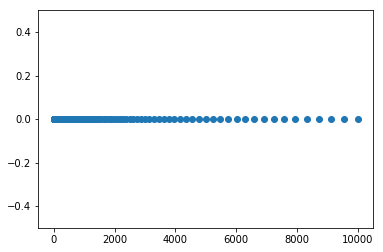

In [67]:
sample_size = 200
x = np.logspace(0, 4, num=sample_size, base=10, endpoint=True)
x
plt.plot(x, np.zeros(sample_size), 'o')
plt.ylim([-0.5, +0.5])
plt.show()

### Set up the y axis for output voltage

The repsonse variable is Vo. It is calculated from circuit analysis of the voltage-divider. We have an input voltage (Vi) of 5V.

Vo = R2/(R1+R2) * Vi

Let's start with R1 of 5k Ohms. Later, we will look at the response curves with R1 at lower and higher settings in fixed steps of 1 K Ohms from 5 k Ohms. 

Plugging these values in the equation:

Vo = R2/(5+R2) * 5

Note that all resistance values are in kilo Ohms. We will use a function `responseVoltage()` to calculate.

In [68]:
def responseVoltage(r2, r1=5, Vi=5):
    '''
    Returns the output voltage of a voltage-divider in Volts.
    inputs:
    r2 - (numeric) impedance of photoresistor in kilo Ohms
    r1 - (numeric) resistance in series with photoresistor in kilo Ohms, defaults to 5k Ohms.
    Vi - (numeric) input voltage in Volts, defaults to 5V
    '''
    return (r2*Vi)/(r1+r2)

assert responseVoltage(5)==2.5, "It shoudl be 2.5V"
assert responseVoltage(0)==0.0, "It should be 0V in ambient light"
assert responseVoltage(5000) > 4.5, "It should be near 5V in dark"

Vectorization in numpy comes in handy for iterative computation that generates an output array from an input array. We will compute values of the response variable like so.

In [69]:
y = np.vectorize(responseVoltage)(x)

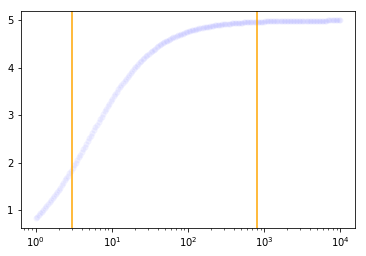

In [76]:
fig = plt.figure()
ax = plt.gca()
ax.plot(x, y, 'o', c='blue', alpha=0.05, markeredgecolor="none")
ax.set_xscale('log')
plt.axvline(x=3, c='orange')
plt.axvline(x=800, c='orange')


### Analysis

The response curve shows that as the photoresistor impedance rises, the output voltage shows a steep rise followed by saturation. Note that the x axis is log-scale, so the linear regime reflects roughly an order of magnitude increase in photoresistor impedance for 1 unit increase in output voltage. 

The nature of this curve shows a design challenge. The min and max impedance corresponding to light and dark conditions are shown with vertical lines at 3k Ohms and 800k Ohms. At the lower end of the scale, the output voltage is already near 2V. The impedance of the photoresistor doesn't go below 1k Ohms even in bright daylight or the equivalent inside lighting conditions. Let's look at the possibilities with a few other values of R1.

## Response curves at different values of series resistor

### Set up the x axis for photoresistor impedance

We will retain the x axis from the previous section and compute a response curve for each candidate value of the series resistor, from 1k Ohms to 9k Ohms in steps of 1k Ohms.

In [78]:
x = np.logspace(0, 4, num=sample_size, base=10, endpoint=True)

### Set up the y axis for output voltage

We will use subscript with y to designate the resistance in kilo Ohms. Thus `y_5` is the response curve for the 5k Ohms resistor.  

In [84]:
y_1 = np.vectorize(lambda x: responseVoltage(x, r1=1))(x)

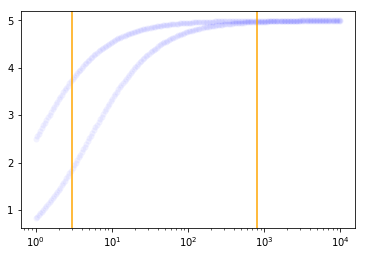

In [85]:
fig = plt.figure()
ax = plt.gca()
ax.plot(x, y, 'o', c='blue', alpha=0.05, markeredgecolor="none")
ax.plot(x, y_1, 'o', c='blue', alpha=0.05, markeredgecolor="none")
ax.set_xscale('log')
plt.axvline(x=3, c='orange')
plt.axvline(x=800, c='orange')

We can automate this with list comprehension.

In [86]:
y_ = [np.vectorize(lambda x: responseVoltage(x, r1=res))(x) for res in np.arange(1, 10)]

In [101]:
len(y_)

9

### Plot the response curves for analysis

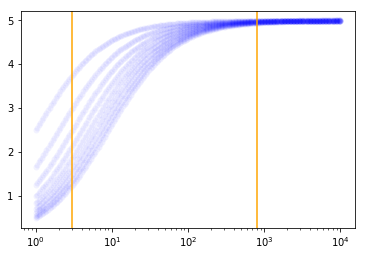

In [103]:
fig = plt.figure()
ax = plt.gca()
for y_i in y_:
    ax.plot(x, y_i, 'o', c='blue', alpha=0.05, markeredgecolor="none")
ax.set_xscale('log')
plt.axvline(x=3, c='orange')
plt.axvline(x=800, c='orange')

#### Analysis

The response curves show the limitations with a photoresistor in voltage-divider configuration. Even with a wide range of series resistor, the logic low remains above target levels.

## Conclusion

Use of a photoresistor in voltage-divider configuration poses some limitations on representing logic low. This is because the impedance of the photoresistor in ambient light is in kilo ohms. Recommendations are as follows:
1. Use photoresistors in combination as resistors in parallel. The drives down the net impedance to lower values.
2. Use a suitable MOSFET with the output voltage as the trigger to obtain logic levels suitable for use with GPIO.